# L5: Automate Event Planning

In this lesson, you will learn more about Tasks.

The libraries are already installed in the classroom. If you're running this notebook on your own machine, you can install the following:
```Python
!pip install crewai==0.28.8 crewai_tools==0.1.6 langchain_community==0.0.29
```

In [1]:
# Warning control
import warnings
warnings.filterwarnings('ignore')

- Import libraries, APIs and LLM

In [2]:
from crewai import Agent, Crew, Task

**Note**: 
- The video uses `gpt-4-turbo`, but due to certain constraints, and in order to offer this course for free to everyone, the code you'll run here will use `gpt-3.5-turbo`.
- You can use `gpt-4-turbo` when you run the notebook _locally_ (using `gpt-4-turbo` will not work on the platform)
- Thank you for your understanding!

In [3]:
import os
from utils import get_openai_api_key,get_serper_api_key

openai_api_key = get_openai_api_key()
os.environ["OPENAI_MODEL_NAME"] = 'gpt-3.5-turbo'
os.environ["SERPER_API_KEY"] = get_serper_api_key()

## crewAI Tools

In [4]:
from crewai_tools import ScrapeWebsiteTool, SerperDevTool

# Initialize the tools
search_tool = SerperDevTool()
scrape_tool = ScrapeWebsiteTool()

## Creating Agents

In [5]:
# Agent 1: Venue Coordinator
venue_coordinator = Agent(
    role="Venue Coordinator",
    goal="Identify and book an appropriate venue "
    "based on event requirements",
    tools=[search_tool, scrape_tool],
    verbose=True,
    backstory=(
        "With a keen sense of space and "
        "understanding of event logistics, "
        "you excel at finding and securing "
        "the perfect venue that fits the event's theme, "
        "size, and budget constraints."
    )
)

In [6]:
 # Agent 2: Logistics Manager
logistics_manager = Agent(
    role='Logistics Manager',
    goal=(
        "Manage all logistics for the event "
        "including catering and equipmen"
    ),
    tools=[search_tool, scrape_tool],
    verbose=True,
    backstory=(
        "Organized and detail-oriented, "
        "you ensure that every logistical aspect of the event "
        "from catering to equipment setup "
        "is flawlessly executed to create a seamless experience."
    )
)

In [7]:
# Agent 3: Marketing and Communications Agent
marketing_communications_agent = Agent(
    role="Marketing and Communications Agent",
    goal="Effectively market the event and "
         "communicate with participants",
    tools=[search_tool, scrape_tool],
    verbose=True,
    backstory=(
        "Creative and communicative, "
        "you craft compelling messages and "
        "engage with potential attendees "
        "to maximize event exposure and participation."
    )
)

## Creating Venue Pydantic Object

- Create a class `VenueDetails` using [Pydantic BaseModel](https://docs.pydantic.dev/latest/api/base_model/).
- Agents will populate this object with information about different venues by creating different instances of it.

In [8]:
from pydantic import BaseModel
# Define a Pydantic model for venue details 
# (demonstrating Output as Pydantic)
class VenueDetails(BaseModel):
    name: str
    address: str
    capacity: int
    booking_status: str

## Creating Tasks
- By using `output_json`, you can specify the structure of the output you want.
- By using `output_file`, you can get your output in a file.
- By setting `human_input=True`, the task will ask for human feedback (whether you like the results or not) before finalising it.

In [9]:
venue_task = Task(
    description="Find a venue in {event_city} "
                "that meets criteria for {event_topic}.",
    expected_output="All the details of a specifically chosen"
                    "venue you found to accommodate the event.",
    human_input=True,
    output_json=VenueDetails,
    output_file="venue_details.json",  
      # Outputs the venue details as a JSON file
    agent=venue_coordinator
)

- By setting `async_execution=True`, it means the task can run in parallel with the tasks which come after it.

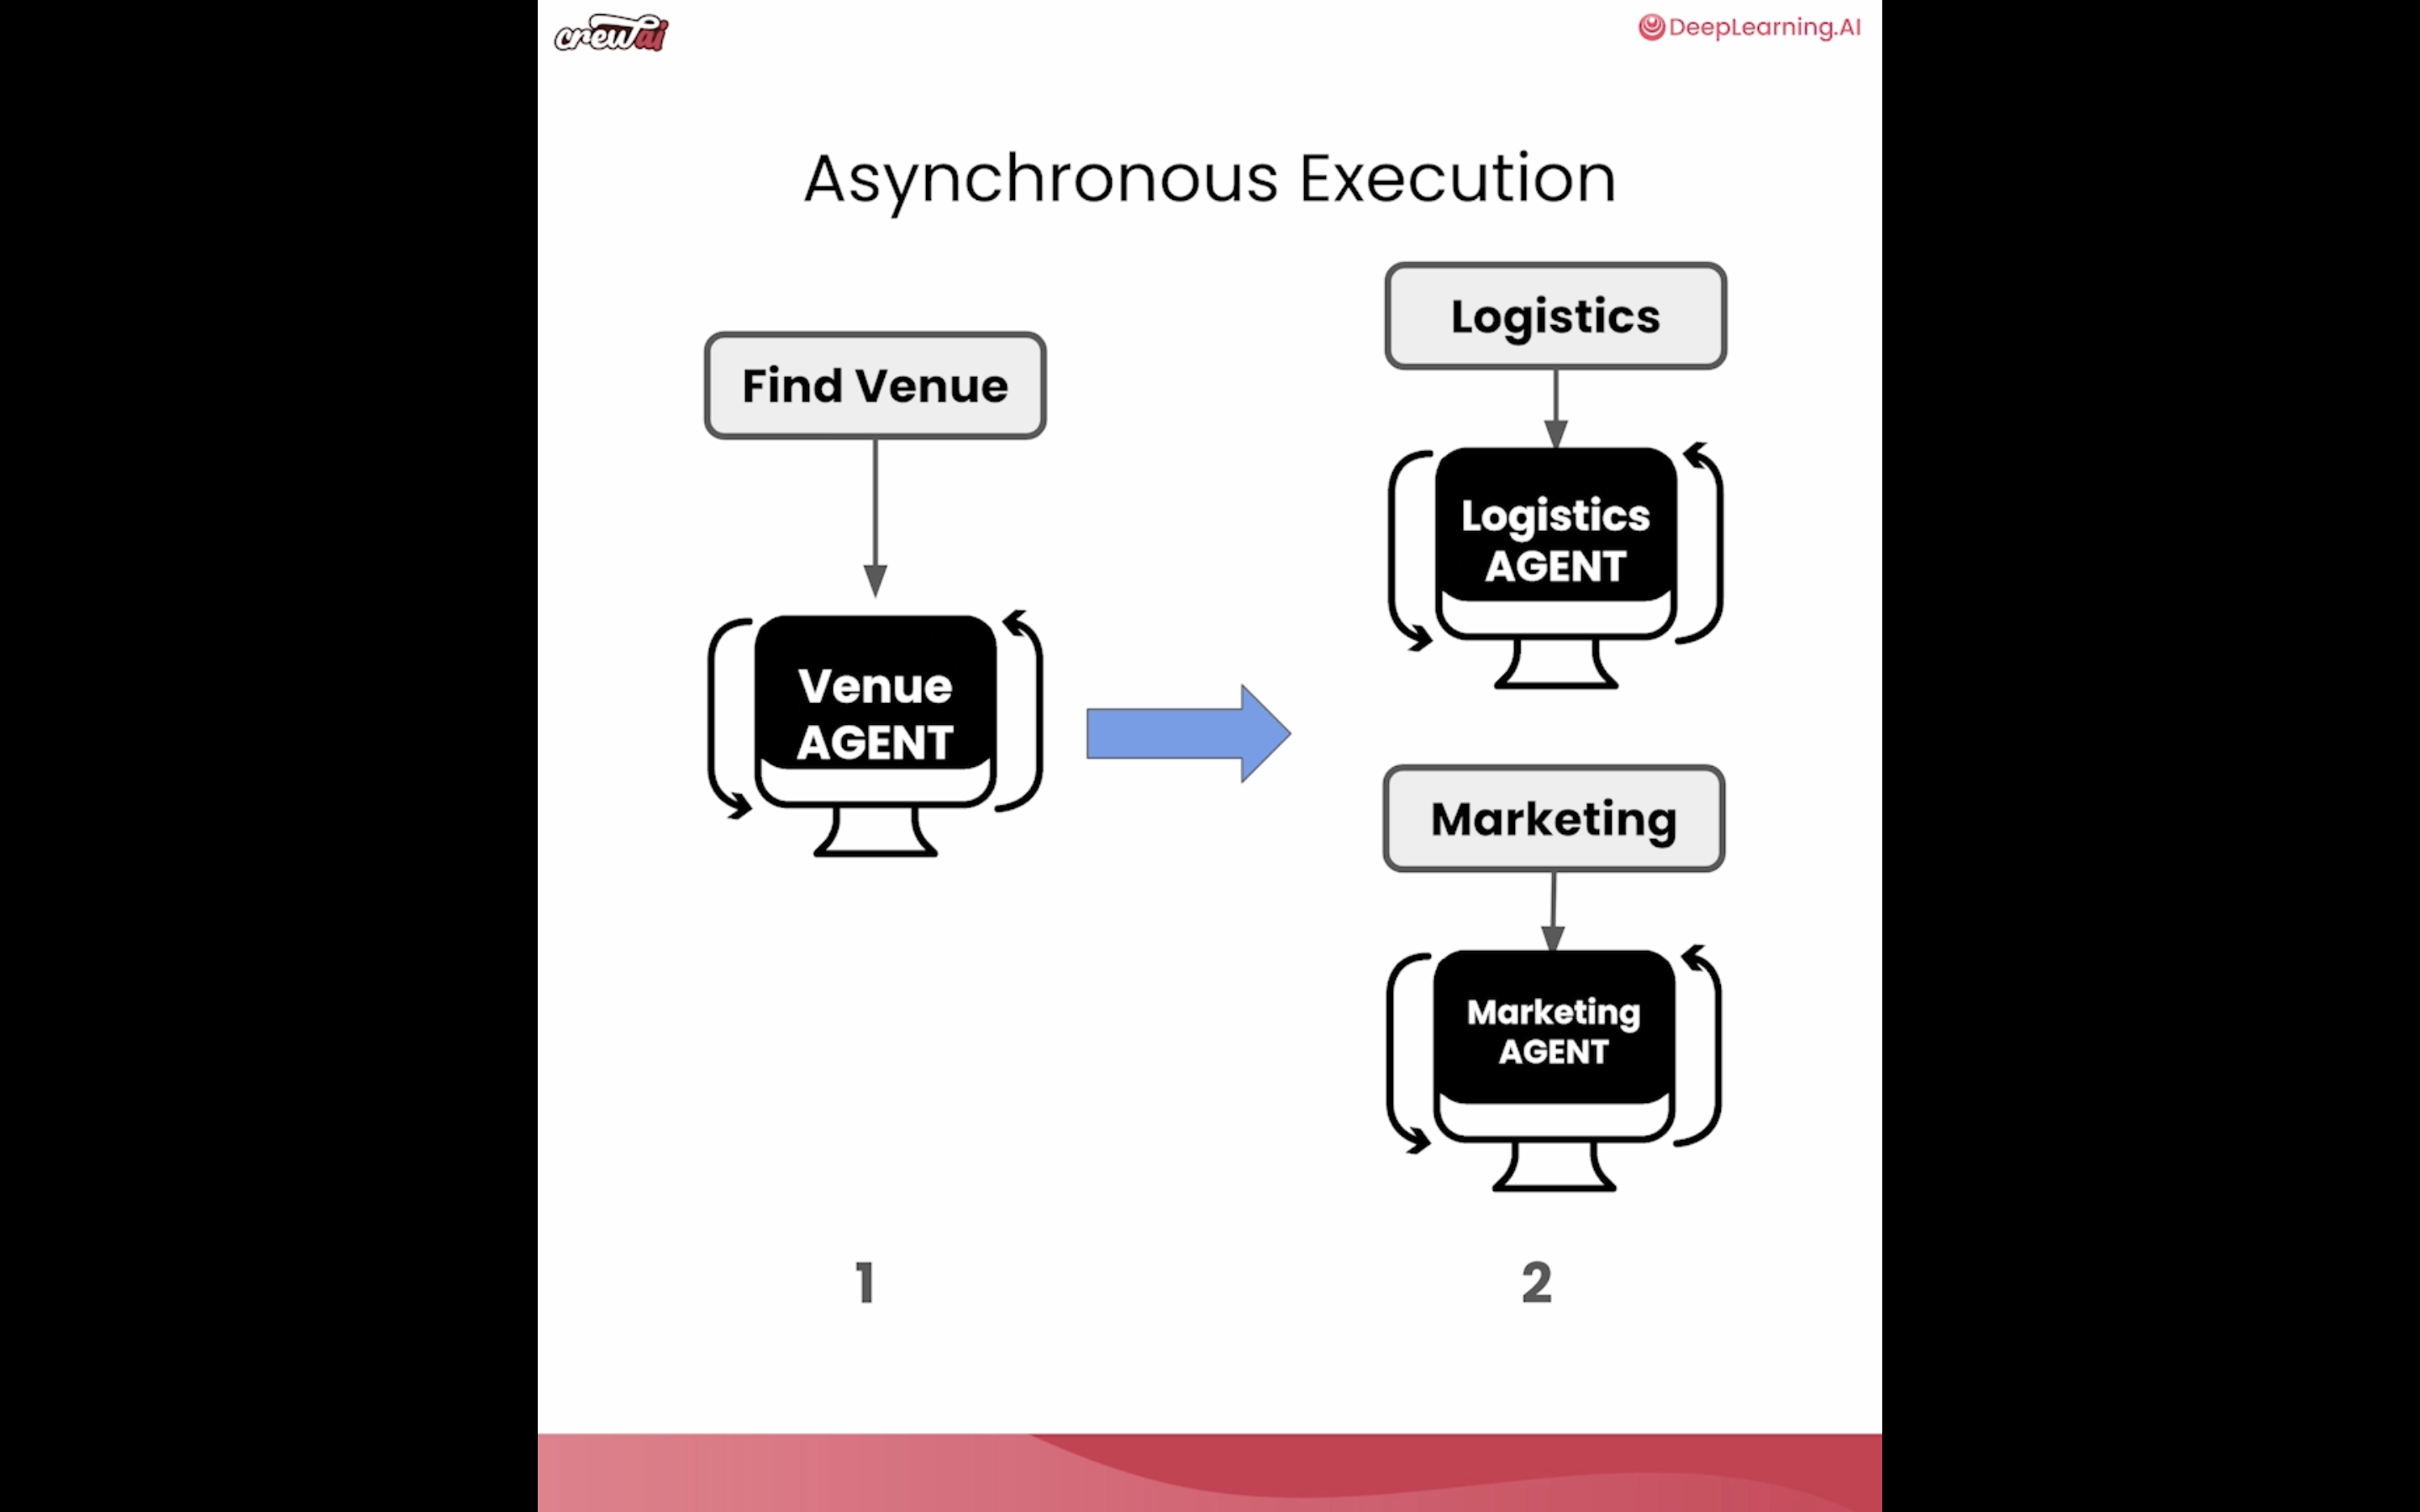

In [10]:
logistics_task = Task(
    description="Coordinate catering and "
                 "equipment for an event "
                 "with {expected_participants} participants "
                 "on {tentative_date}.",
    expected_output="Confirmation of all logistics arrangements "
                    "including catering and equipment setup.",
    human_input=True,
    async_execution=True,
    agent=logistics_manager
)

In [11]:
marketing_task = Task(
    description="Promote the {event_topic} "
                "aiming to engage at least"
                "{expected_participants} potential attendees.",
    expected_output="Report on marketing activities "
                    "and attendee engagement formatted as markdown.",
    async_execution=True,
    output_file="marketing_report.md",  # Outputs the report as a text file
    agent=marketing_communications_agent
)

## Creating the Crew

**Note**: Since you set `async_execution=True` for `logistics_task` and `marketing_task` tasks, now the order for them does not matter in the `tasks` list.

In [12]:
# Define the crew with agents and tasks
event_management_crew = Crew(
    agents=[venue_coordinator, 
            logistics_manager, 
            marketing_communications_agent],
    
    tasks=[venue_task, 
           logistics_task, 
           marketing_task],
    
    verbose=True
)

## Running the Crew

- Set the inputs for the execution of the crew.

In [13]:
event_details = {
    'event_topic': "Tech Innovation Conference",
    'event_description': "A gathering of tech innovators "
                         "and industry leaders "
                         "to explore future technologies.",
    'event_city': "San Francisco",
    'tentative_date': "2024-09-15",
    'expected_participants': 500,
    'budget': 20000,
    'venue_type': "Conference Hall"
}

**Note 1**: LLMs can provide different outputs for they same input, so what you get might be different than what you see in the video.

**Note 2**: 
- Since you set `human_input=True` for some tasks, the execution will ask for your input before it finishes running.
- When it asks for feedback, use your mouse pointer to first click in the text box before typing anything.

In [15]:
result = event_management_crew.kickoff(inputs=event_details)

 [DEBUG]: == Working Agent: Venue Coordinator
 [INFO]: == Starting Task: Find a venue in San Francisco that meets criteria for Tech Innovation Conference.


> Entering new CrewAgentExecutor chain...
I need to find a venue in San Francisco that meets the criteria for the Tech Innovation Conference. I should consider the theme, size, and budget constraints when selecting the venue.

Action: Search the internet
Action Input: {"search_query": "tech conference venues in San Francisco"} 


Search results: Title: Discover Tech Conferences Events & Activities in San Francisco, CA
Link: https://www.eventbrite.com/d/ca--san-francisco/tech-conferences/
Snippet: Tech conferences events in San Francisco, CA ; Tech Dating 21-30 in San Francisco. Wed, Dec 18 • 6:00 PM + 8 more. Toy Soldier · Circle Dating ; Tech & Business ...
---
Title: Top 12 tech conferences in San Francisco for 2024 - TravelPerk
Link: https://www.travelperk.com/blog/top-tech-conferences-in-san-francisco/
Snippet: Santa Clara Conv

This is the agent final answer: Venue: The Whole Venue at The American Bookbinders Museum
Location: South of Market (SOMA), San Francisco, CA
Description: Industrial-Modern Museum Space located at 355 Clementina Street, in the heart of SOMA. The venue is suitable for hosting conferences, offsite meetings, or memorable events. It offers a unique setting that combines industrial and modern elements.
Capacity: Accommodates up to 110 guests
Price: Starting from $375 per hour
Features: The venue provides a versatile space with a blend of historic and contemporary aesthetics. It offers a distinctive atmosphere that can enhance the experience of attendees. The location is easily accessible and provides a memorable setting for the Tech Innovation Conference.
Please provide a feedback: yesss
Final Answer: 
Venue: The Whole Venue at The American Bookbinders Museum
Location: South of Market (SOMA), San Francisco, CA
Description: Industrial-Modern Museum Space located at 355 Clementina Street, in 

Thought: I need to gather information about potential attendees and promote the Tech Innovation Conference effectively.

Action: Search the internet
Action Input: {"search_query": "Tech Innovation Conference attendees list"} 


Search results: Title: Top 20 Venues in SoMa, San Francisco, CA - PartySlate
Link: https://www.partyslate.com/find-venues/near/soma-san-francisco-ca-usa
Snippet: Located in San Francisco's South of Market convention district, The Box SF is an elegantly cool private meeting and event space perfect for small daytime, ...
---
Title: Rent a party venue in South of Market, San Francisco, CA - Peerspace
Link: https://www.peerspace.com/neighborhood/south-of-market--san-francisco--ca/party-venue
Snippet: Rent a party venue in South of Market, San Francisco, CA. Discover and book unique spaces directly from hosts in South of Market, San Francisco, CA.
---
Title: SoMa, San Francisco, CA - Venues & Event Spaces - Yelp
Link: https://www.yelp.com/search?cflt=venues&find_loc=

Thought: I need to gather information about potential attendees and promote the Tech Innovation Conference effectively.

Action: Search the internet
Action Input: {"search_query": "Tech Innovation Conference potential attendees"}Thought: 
I need to ensure that all logistics for the event are arranged flawlessly, including catering and equipment setup. 

Action: Delegate work to co-worker
Action Input: {
  "coworker": "Venue Coordinator",
  "task": "Coordinate catering and equipment setup for an event with 500 participants on 2024-09-15 at The Whole Venue at The American Bookbinders Museum located at 355 Clementina Street, South of Market (SOMA), San Francisco, CA with a capacity of 110 and booking status as Available.",
  "context": "I need you to coordinate catering and equipment setup for an event with 500 participants on 2024-09-15 at The Whole Venue at The American Bookbinders Museum located at 355 Clementina Street, South of Market (SOMA), San Francisco, CA with a capacity of 110 

Thought: I need to gather information about potential attendees and promote the Tech Innovation Conference effectively.

Action: Search the internet
Action Input: {"search_query": "Tech Innovation Conference attendees list"} 


Search results: Title: Exhibitors | Gartner Tech Growth & Innovation Conference 2025, in ...
Link: https://www.gartner.com/en/conferences/na/tech-growth-us/exhibitors
Snippet: Discover top exhibitors and meet leading technology providers at Gartner Tech Growth & Innovation Conference 2025 to address your mission-critical ...
---
Title: Showcase Participants - ARPA-E Energy Innovation Summit
Link: https://www.arpae-summit.com/Showcase/Showcase-Participants
Snippet: The list below only includes participants that have currently registered to be part of the 2025 Technology Showcase.
---
Title: Technology & Innovation Summit North America - Forrester
Link: https://www.forrester.com/event/technology-innovation-north-america/
Snippet: Registered attendees of Technology

Thought: Based on the search results, I need to check the details on Tagvenue regarding The Whole Venue at The American Bookbinders Museum.

Action: Read website content
Action Input: {"website_url": "https://www.tagvenue.com/us/rooms/san-francisco/62877/the-american-bookbinders-museum/the-whole-venue"} 

The Whole Venue - The American Bookbinders Museum - Event Venue Rental - Tagvenue.com
See all13 photos
 The Whole Venue at The American Bookbinders Museum
 Event Space in a Museum
·
 Whole venue
 5 reviews
 36 reviews
  – 
 Read all
 355 Clementina Street, San Francisco, CA 94103
 –
 Show map
 South of Market (SOMA), San Francisco, CA
Up to 110seats
Up to 110standing
 Venue doesn’t offer catering
 External catering allowed
About this space
This distinctive location boasts a spacious open area suitable for various events such as meetings, receptions, parties, weddings, and even fashion shows! 
Showcasing 19th-century bookbinding equipment and ephemera, every corner of this museum space

Final Answer: 
Based on the information gathered from the Tagvenue website, The Whole Venue at The American Bookbinders Museum located at 355 Clementina Street, South of Market (SOMA), San Francisco, CA can accommodate up to 110 guests standing and up to 110 seated. The venue does not offer catering but allows external catering. The prices for renting the venue range from $375 to $499 per hour, depending on the day and time of the event. The minimum booking duration is 4 hours. The venue has various event packages and spaces available, making it a versatile option for different types of events.

> Finished chain.
 

Based on the information gathered from the Tagvenue website, The Whole Venue at The American Bookbinders Museum located at 355 Clementina Street, South of Market (SOMA), San Francisco, CA can accommodate up to 110 guests standing and up to 110 seated. The venue does not offer catering but allows external catering. The prices for renting the venue range from $375 to $499 per

Exception in thread Thread-9 (_execute):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/usr/local/lib/python3.11/threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.11/site-packages/crewai/task.py", line 182, in _execute
    result = agent.execute_task(
             ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/site-packages/crewai/agent.py", line 221, in execute_task
    result = self.agent_executor.invoke(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/site-packages/langchain/chains/base.py", line 163, in invoke
    raise e
  File "/usr/local/lib/python3.11/site-packages/langchain/chains/base.py", line 153, in invoke
    self._call(inputs, run_manager=run_manager)
  File "/us

- Display the generated `venue_details.json` file.

In [16]:
import json
from pprint import pprint

with open('venue_details.json') as f:
   data = json.load(f)

pprint(data)

{'address': '355 Clementina Street, South of Market (SOMA), San Francisco, CA',
 'booking_status': 'Available',
 'capacity': 110,
 'name': 'The Whole Venue at The American Bookbinders Museum'}


- Display the generated `marketing_report.md` file.

**Note**: After `kickoff` execution has successfully ran, wait an extra 45 seconds for the `marketing_report.md` file to be generated. If you try to run the code below before the file has been generated, your output would look like:

```
marketing_report.md
```

If you see this output, wait some more and than try again.

In [17]:
from IPython.display import Markdown
Markdown("marketing_report.md")

## Marketing Activities and Attendee Engagement Report

### Marketing Activities:
1. Utilized internet searches to gather information about potential attendees and details of the Tech Innovation Conference.
2. Explored various websites, such as Bizzabo and Forrester, to understand the landscape of tech conferences in 2025.
3. Identified key conferences like the Gartner Tech Growth & Innovation Conference and CES, which are influential in the tech industry.
4. Conducted searches for attendee lists and exhibitor information to target potential participants effectively.
5. Identified the venue of the conference to provide attendees with necessary details for planning their participation.

### Attendee Engagement:
1. Discovered top exhibitors and showcased participants for the Gartner Tech Growth & Innovation Conference 2025.
2. Explored the Technology & Innovation Summit North America to understand attendee access to digital hubs.
3. Investigated Defense Innovation Exhibitors at TechConnect to recognize key companies attending the event.
4. Reviewed past attendees of the Retail Innovation Conference & Expo to understand the caliber of participants at similar events.
5. Explored participant information for the Innovation Conference to understand the registration process and event details.

By leveraging these insights, we can effectively market the Tech Innovation Conference and engage with potential attendees to maximize event exposure and participation.